In [15]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd
import checker
import utils

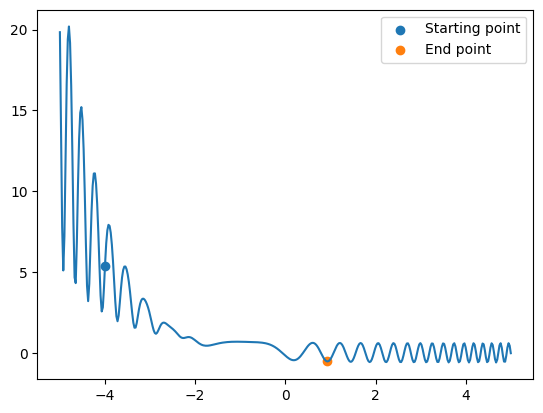

In [16]:
def gradient_descent(loss, X, parameters, y=None, lr=1e-6, num_steps=int(1e4)):
    for idx in range(num_steps):
        # Informujemy PyTorcha, że chcemy dostać gradient po naszych parametrach
        parameters.requires_grad = True

        # Liczymy wartość funkcji kosztu.
        loss_val = loss(X, parameters, y)

        # Każemy PyTorchowi policzyć gradient
        loss_val.backward()

        # Wyciągamy gradient po parametrach
        gradient = parameters.grad

        # Wykonujemy krok metody spadku gradientu
        with torch.no_grad():
            parameters = parameters - lr * gradient

    # Zwracamy najlepsze parametry
    return parameters

# Dziwna funkcja, której minimum będziemy chcieli znaleźć.
def complex_fn(a, x, _=None):
    y = a[0] / a[1] * torch.cos(a[0] * x ** 2 + a[1] * x - a[2])
    z = torch.exp(-x) / (y + 3)
    return -(z + y) + torch.exp(-x - 0.8)

a = torch.tensor([3., 5., 1.])
x = torch.tensor(-4.)
result = gradient_descent(complex_fn, a, x, lr=2e-2, num_steps=int(2e4))

utils.plot_torch_fn(complex_fn, a, x, result)

In [17]:
# Preparing datasets
torch.manual_seed(5)

# Regression dataset - Boston housing (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html)

data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
boston_data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
boston_target = raw_df.values[1::2, 2]

boston_X = torch.tensor(boston_data, dtype=torch.float32)
boston_y = torch.tensor(boston_target, dtype=torch.float32)
boston_w = torch.randn(boston_X.shape[1], dtype=torch.float32, requires_grad=True)


boston_data = (boston_X, boston_y, boston_w)

# Multidimensional datasets
dataset_5d = torch.randn([1000, 5], dtype=torch.float32)
param_5d = torch.randn(5, requires_grad=True)

dataset_20d = torch.randn([325, 20], dtype=torch.float32)
param_20d = torch.randn(20, requires_grad=True)

multi_datasets = [(dataset_5d, param_5d), (dataset_20d, param_20d)]

In [18]:
def mean_squared_error(X: torch.Tensor, theta: torch.Tensor) -> torch.Tensor:
    # TODO - przepisz implementację z numpy na PyTorcha
    squared_distances = (X-theta).pow(2).sum(dim=1)
    return squared_distances.mean()

checker.check_4_1_mse(mean_squared_error, multi_datasets)

In [19]:
def mean_error(X: torch.Tensor, theta: torch.Tensor) -> torch.Tensor:
    return (X-theta).norm(dim=-1).mean()
checker.check_4_1_me(mean_error, multi_datasets)

In [20]:
def max_error(X: torch.Tensor, theta: torch.Tensor) -> torch.Tensor:
    return (X-theta).norm(dim=-1).max()
checker.check_4_1_max(max_error, multi_datasets)

In [21]:
def linear_regression_loss(X: torch.Tensor, w: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    return ((torch.matmul(X, w) - y)**2).mean()
checker.check_4_1_lin_reg(linear_regression_loss, boston_data)

In [22]:
def regularized_regression_loss(X: torch.Tensor, w: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    alpha = 0.2
    predicted = torch.matmul(X, w)
    return (torch.add(predicted - y, alpha)**2 ).mean()

checker.check_4_1_reg_reg(regularized_regression_loss, boston_data)

AssertionError: Wrong loss returned!

In [ ]:
plt.xlabel("x")
plt.ylabel("sigma(x)")

X = np.linspace(-6, 6)
plt.plot(X, 1 / (1 + np.exp(-X)))
plt.show()

In [ ]:
# Przygotujmy datasety i funkcje pomocnicze
dataset_1d = utils.get_classification_dataset_1d()
dataset_2d = utils.get_classification_dataset_2d()

def calculate_accuracy(logistic_reg, X, y):
    preds = logistic_reg.predict(X)
    correct_n = (preds == y).float().sum().item()
    return correct_n / len(y)

def plot_dataset_1d(logistic_reg, dataset_1d):
    plt.scatter(dataset_1d.data[:10], [0.5] * 10, c="purple", label="0")
    plt.scatter(dataset_1d.data[10:], [0.5] * 10, c="yellow", label="1")
    linspace = torch.linspace(-7.5, 15, steps=100).view(-1, 1)
    plt.plot(
        linspace.numpy().ravel(),
        logistic_reg.predict_proba(linspace).detach().numpy(),
        label="p(y=1 | x)"
    )
    plt.legend()
    plt.show()

def plot_dataset_2d(logistic_reg, dataset_2d):
    plt.scatter(dataset_2d.data[:50, 0], dataset_2d.data[:50, 1], c="purple", label="0")
    plt.scatter(dataset_2d.data[50:, 0], dataset_2d.data[50:, 1], c="yellow", label="1")

    linspace_x = torch.linspace(-4, 7, steps=100)
    linspace_y = (-logistic_reg.bias - logistic_reg.weight[0] * linspace_x) / logistic_reg.weight[1]

    linspace_y = linspace_y.detach().numpy()
    plt.plot(linspace_x.detach().numpy(), linspace_y, label="Granica decyzyjna")
    plt.legend()

In [ ]:


class LogisticRegression:
    def __init__(self, input_dim):
        self.weight = None
        self.bias = None
        self.input_dim = input_dim

    def _sigmoid(self, x):
        return 1 / (1 + torch.exp(-x))

    def fit(self, X, y, lr=1e-6, num_steps=int(1e4)):
        self.weight = torch.randn(self.input_dim, requires_grad=True)
        self.bias = torch.randn((), requires_grad=True)
        for idx in range(num_steps):
            self.weight.requires_grad = True
            self.bias.requires_grad = True

            loss_val = self.loss(X, y)
            loss_val.backward()

            w_grad = self.weight.grad
            b_grad = self.bias.grad
            with torch.no_grad():
                self.weight = self.weight - lr * w_grad
                self.bias = self.bias - lr * b_grad

    def predict_proba(self, X: torch.Tensor) -> torch.Tensor:
        with torch.no_grad():
            proba = self.predict(X)
        return proba

    def predict(self, X: torch.Tensor) -> torch.FloatTensor:
        return self._sigmoid(X)

    def loss(self, X: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        z = self.weight.T * X  + self.bias
        preds = self._sigmoid(z)
        entropy = (-(1 - y)*torch.log(1-preds) - y*torch.log(preds)).mean()
        return entropy

In [ ]:
checker.check_04_logistic_reg(LogisticRegression)

In [ ]:
logistic_reg = LogisticRegression(1)
logistic_reg.fit(dataset_1d.data, dataset_1d.target, lr=1e-3, num_steps=int(2e4))
acc = calculate_accuracy(logistic_reg, dataset_1d.data, dataset_1d.target)
print("Accuracy", acc)

plot_dataset_1d(logistic_reg, dataset_1d)

In [23]:
logistic_reg = LogisticRegression(2)
logistic_reg.fit(dataset_2d.data, dataset_2d.target, lr=1e-2, num_steps=int(2e4))
acc = calculate_accuracy(logistic_reg, dataset_2d.data, dataset_2d.target)
print("Accuracy", acc)

plot_dataset_2d(logistic_reg, dataset_2d)

RuntimeError: The size of tensor a (100) must match the size of tensor b (2) at non-singleton dimension 1

In [24]:
# Przygotujmy sobie dane do testów
input = torch.randn(30, 20, dtype=torch.double, requires_grad=True) * 3
a = torch.randn(20, 30, requires_grad=True).double() * 2 - 5
b = torch.randn(20, 30, requires_grad=True).double() + 6


preds = torch.rand(30, requires_grad=True).double()
labels_dist = torch.distributions.Bernoulli(probs=0.7)
labels = labels_dist.sample([30]).double()

In [25]:
class MyProduct(torch.autograd.Function):

    @staticmethod
    def forward(self, a, b):
        self.save_for_backward(a, b)
        return a * b

    @staticmethod
    def backward(self, grad_output):
        # Wyjmujemy z pamięci a oraz b
        a, b = self.saved_tensors
        # Liczymy pochodną po a
        a_grad = b
        # Liczymy pochodną po b
        b_grad = a

        # Zwracamy "łańcuchowe" pochodne
        return grad_output * a_grad, grad_output * b_grad

prod_fn = MyProduct.apply
torch.autograd.gradcheck(prod_fn, (a, b), eps=1e-3, atol=1e-2, rtol=1e-2)

True

In [26]:
class MyAdd(torch.autograd.Function):
    @staticmethod
    def forward(self, a, b):
        self.save_for_backward(a, b)
        return a + b

    @staticmethod
    def backward(self, grad_output):
        a, b = self.saved_tensors
        a_grad = 1
        b_grad = 1
        return grad_output * a_grad, grad_output * b_grad

add_fn = MyAdd.apply
torch.autograd.gradcheck(add_fn, (a, b), eps=1e-3, atol=1e-2, rtol=1e-2)

True

In [27]:


class MyDiv(torch.autograd.Function):
    @staticmethod
    def forward(self, a, b):
        self.save_for_backward(a, b)
        return a / b

    @staticmethod
    def backward(self, grad_output):
        a, b = self.saved_tensors
        a_grad = 1/b
        b_grad = -a / (b**2)
        return grad_output * a_grad, grad_output * b_grad

div_fn = MyDiv.apply
torch.autograd.gradcheck(div_fn, (a, b), eps=1e-3, atol=1e-2, rtol=1e-2)



True

In [28]:
class MySigmoid(torch.autograd.Function):
    @staticmethod
    def forward(self, input_):
        self.save_for_backward(input_)
        return 1 / (1 + torch.exp(-input_))

    @staticmethod
    def backward(self, grad_output):
        input_, = self.saved_tensors
        sigmoid = 1 / (1 + torch.exp(-input_) )
        z_grad = sigmoid * (1 - sigmoid)
        return grad_output * z_grad


sigmoid_fn = MySigmoid.apply
torch.autograd.gradcheck(sigmoid_fn, input)

True

In [29]:
class MyBinaryCrossEntropy(torch.autograd.Function):
    @staticmethod
    def forward(self, preds, labels, bias=None):
        self.save_for_backward(preds, labels)
        return (-(1 - labels)*torch.log(1-preds) - labels*torch.log(preds)).mean()

    @staticmethod
    def backward(self, grad_output):
        preds, labels = self.saved_tensors
        grad_labels = None
        grad_preds = ( 1/len(preds) ) * ( -labels/preds + (1-labels)/(1-preds))
        return  grad_output * grad_preds , grad_labels

bce_fn = MyBinaryCrossEntropy.apply
torch.autograd.gradcheck(bce_fn, (preds, labels), eps=1e-3, atol=1e-2, rtol=1e-1)

True

In [30]:
# Przygotowujemy prosty dataset
X = torch.cat([
    torch.randn(10) * 3 + 2,
    torch.randn(10) * 3 + 12
])
y = torch.cat([torch.zeros(10), torch.ones(10)])


# Inicjalizujemy zmienne
weight = torch.randn((), requires_grad=True)
bias = torch.randn((), requires_grad=True)

lr = 1e-1
for idx in range(10000):
    weight.requires_grad = True
    bias.requires_grad = True

    # Liczymy funkcję kosztu za pomocą naszych modułów
    logit = add_fn(prod_fn(weight, X), bias)
    pred = sigmoid_fn(logit)
    loss = bce_fn(pred, y)

    # Gradient przechodzi przez funkcję backward każdego modułu
    loss.backward()

    # Wyciągamy gradienty
    w_grad = weight.grad
    b_grad = bias.grad

    # Wykonujemy krok metody spadku gradientu
    with torch.no_grad():
        weight = weight - lr * w_grad
        bias = bias - lr * b_grad

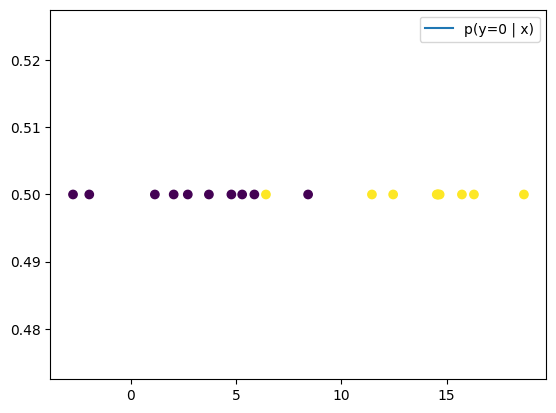

In [31]:
plt.scatter(X, np.zeros_like(X) + 0.5, c=y.numpy())

linspace = torch.linspace(-5, 15, steps=100).view(-1, 1)
with torch.no_grad():
    plt.plot(
        linspace.numpy().ravel(),
        sigmoid_fn(add_fn(prod_fn(weight, linspace), bias)).detach().numpy(),
        label="p(y=0 | x)"
    )
    plt.legend()